In [71]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


class PLACES:
  PARK = 0
  HOME = 1
  GROCERY = 2
  QC = 3


class INFECTION_STATES:
  NOT_INFECTED = 0
  INFECTED_A = 1
  INFECTED_S = 2
  CRITICAL = 3
  CURED = 4
  DECEASED = 5


STATES = INFECTION_STATES  # Alias
CONTAGIOUS_STATES = [STATES.INFECTED_A, STATES.INFECTED_S, STATES.CRITICAL]


class CONFIG(object):
  def __init__(
          self,
          numAgents=1000,
          qcLimit=0,
          parks=2,
          groceryStores=5,
          quarantine=False,
          socialDistancing=False,
          proportionInfected=0.1):
    self.numAgents = numAgents
    self.qcLimit = qcLimit
    self.parks = parks
    self.groceryStores = groceryStores
    self.quarantine = quarantine
    self.socialDistancing = socialDistancing
    self.proportionInfected = proportionInfected

# Functions from the old file


def compute_infected(model):
  infectedAgents = [agent for agent in model.schedule.agents
                    if agent.health in CONTAGIOUS_STATES]

  return len(infectedAgents)


def run_simulation(config=None):
  model = CovidModel(config if config else CONFIG())
  steps = 0
  while any(agent.health in CONTAGIOUS_STATES for agent in model.schedule.agents):
    steps += 1
    model.step()

  modelDataframe = model.datacollector.get_model_vars_dataframe()
  data = {
      "qcOccupancy": modelDataframe.qcOccupancy,
      "infected": modelDataframe.infected,
  }

  return steps, model, data


def plot_average_scenario(config=None, iterations=10):
  avgDays = 0
  avgPeakInfectionDay = 0
  avgPeakInfected = 0
  avgCasualty = 0

  def updateAvg(old, new, i):
    return (new + (old * i))/(i+1)

  plots = None

  for i in range(iterations):
    days, model, plots = run_simulation(config if config else CONFIG())
    infected, qcOccupancy = plots["infected"], plots["qcOccupancy"]
    avgDays = updateAvg(avgDays, days, i)
    avgPeakInfectionDay = updateAvg(avgPeakInfectionDay, infected.idxmax(), i)
    avgPeakInfected = updateAvg(avgPeakInfected, infected.max(), i)
    avgCasualty = updateAvg(avgCasualty, model.deceasedCount, i)

  plots["infected"].plot(legend=True)
  plots["qcOccupancy"].plot(legend=True)

  print(f"Average number of days before stabilisation: {avgDays}")
  print(
      f"Average day with peak infections ({avgPeakInfected}): {avgPeakInfectionDay}")
  print(f"Average number of casualties: {avgCasualty}")


class HumanAgent(Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.homeId = unique_id//4
    self.health = STATES.NOT_INFECTED
    self.model = model

  def step(self):
    '''One time step in the simulation'''
    self.updateHealth()
    self.move()

  def move(self):
    '''Determine next position based on model health and current position'''
    x, y = self.pos
    xNew, yNew = x, y  # assume no move has been made

    # People in quarantine stay there
    if x == PLACES.QC:
      pass

    # Handle quarantine rules
    elif self.model.config.quarantine:
      # If there is room in the quarantine centre
      if self.model.qcOccupancy < self.model.config.qcLimit:
        # p(go to quarantine|critical) = 1.0
        if self.health == STATES.CRITICAL:
          xNew, yNew = PLACES.QC, 0
        # p(go to quarantine|symptomatic) = 0.2
        elif self.health == STATES.INFECTED_S and self.random.uniform(0, 1) <= 0.20:
          xNew, yNew = PLACES.QC, 0
          
    # Home transitions
    elif x == PLACES.HOME:
      p = self.random.uniform(0, 1)
      # p(home -> park) = 0.1
      if p <= 0.1:
        ids = tuple(i for i in range(self.model.config.parks))
        xNew, yNew = PLACES.PARK, self.random.choice(ids)
      # p(home -> grocery store) = 0.2
      elif p <= 0.3:
        ids = tuple(i for i in range(self.model.config.groceryStores))
        xNew, yNew = PLACES.GROCERY, self.random.choice(ids)
      # p(home -> home) = 0.7
      else:
        pass
    # Return home with p=1.0 if anywhere else.
    elif x in [PLACES.GROCERY, PLACES.PARK]:
      xNew, yNew = PLACES.HOME, self.homeId

    # If the agent will quarantine, update the occupancy
    if x != PLACES.QC and xNew == PLACES.QC:
      self.model.qcOccupancy += 1

    self.model.grid.move_agent(self, (xNew, yNew))

  def updateHealth(self):
    '''Update health based on transitions'''
    p = self.random.uniform(0, 1)
    newHealth = self.health
    x, _ = self.pos

    # p(Asymptomatic -> Symptomatic) = 0.25
    if self.health == STATES.INFECTED_A and p > 0.75:
      newHealth = STATES.INFECTED_S

    elif self.health == STATES.INFECTED_S:
      # p(Symptomatic -> Critical) = 0.1
      if p > 0.75 and p <= 0.85:
        newHealth = STATES.CRITICAL
      # p(Symptomatic -> Cured) = 0.15
      elif p > 0.85:
        newHealth = STATES.CURED

    elif self.health == STATES.CRITICAL:
      # p(Critical -> Cured) = 0.2
      if p > 0.75 and p <= 0.95:
        newHealth = STATES.CURED
      # p(Critical -> Deceased) = 0.05
      elif p > 0.95:
        newHealth = STATES.DECEASED
        self.model.deceasedCount += 1

    INACTIVE = [STATES.CURED, STATES.DECEASED]
    # Remove them from the quarantine centre if they are there
    # and are cured or passed away
    if self.health not in INACTIVE and newHealth in INACTIVE:
      if x == PLACES.QC:
        self.model.qcOccupancy -= 1

    # Update health
    self.health = newHealth

  def infect(self):
    p = self.random.uniform(0, 1)
    # p0a = p(NotInfected -> Infected)
    # p0b = 1 - p0a
    # so p > p0b is checking p <= p0a
    if self.health == STATES.NOT_INFECTED and p > self.model.p0b:
      self.health = STATES.INFECTED_A


class CovidModel(Model):
  def __init__(self, config=None):
    self.config = config if config else CONFIG()
    self.qcOccupancy = 0
    self.deceasedCount = 0
    self.grid = MultiGrid(4 if self.config.quarantine else 3, 250, False)
    self.schedule = RandomActivation(self)
    self.running = True

    # If social distancing is in effect, the infection spread probability is reduced
    # p0b = 1 - p(NotInfected -> Infected) = p(NotInfected -> NotInfected)
    self.p0b = 0.9 if self.config.socialDistancing else 0.5

    # Create agents
    for i in range(self.config.numAgents):
      agent = HumanAgent(i, self)
      self.schedule.add(agent)
      self.grid.place_agent(agent, (PLACES.HOME, agent.homeId))

    initial_infected_population = self.config.proportionInfected * self.config.numAgents

    for agent in self.random.sample(self.schedule.agents, int(initial_infected_population)):
      agent.health = STATES.INFECTED_A

    self.datacollector = DataCollector(model_reporters={
        "infected": compute_infected,
        "qcOccupancy": "qcOccupancy"})

  def step(self):
    '''Advance the model by one step'''
    self.datacollector.collect(self)
    self.schedule.step()
    self.identifyAgentsAndUpdateSpread()

  def identifyAgentsAndUpdateSpread(self):
    agents=[]
    # Agents in the park
    for y in range(self.config.parks):
      agents += self.grid.get_cell_list_contents([(PLACES.PARK, y)])
    # Agents shopping
    for y in range(self.config.groceryStores):
      agents += self.grid.get_cell_list_contents([(PLACES.GROCERY, y)])
    # Agents at home
    for y in range(250):
      agents += self.grid.get_cell_list_contents([(PLACES.HOME, y)])

    self.updateSpread(agents)

  def updateSpread(self, agents):
    if any(agent.health in CONTAGIOUS_STATES for agent in agents):
      list(map(lambda agent: agent.infect(), agents))


Average number of days before stabilisation: 38.7
Average day with peak infections (873.6): 3.8
Average number of casualties: 81.3


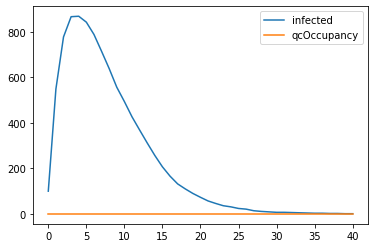

In [73]:
scenario11 = CONFIG(proportionInfected=0.1)
plot_average_scenario(scenario11)

Average number of days before stabilisation: 46.1
Average day with peak infections (868.5): 3.5
Average number of casualties: 79.8


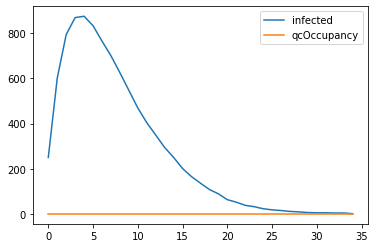

In [74]:
scenario12 = CONFIG(proportionInfected=0.25)
plot_average_scenario(scenario12)

Average number of days before stabilisation: 39.8
Average day with peak infections (871.2): 2.9
Average number of casualties: 82.8


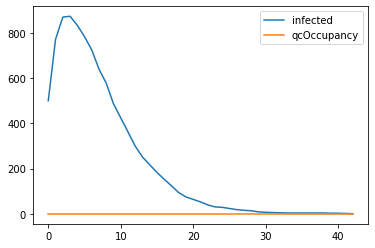

In [75]:
scenario13 = CONFIG(proportionInfected=0.50)
plot_average_scenario(scenario13)

Average number of days before stabilisation: 43.5
Average day with peak infections (870.6): 3.9
Average number of casualties: 78.7


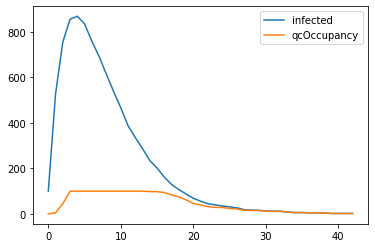

In [76]:

scenario21 = CONFIG(proportionInfected=0.1, qcLimit=100, quarantine=True)
plot_average_scenario(scenario21)

Average number of days before stabilisation: 40.1
Average day with peak infections (869.6): 3.3
Average number of casualties: 76.9


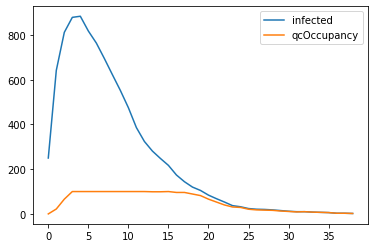

In [77]:

scenario22 = CONFIG(proportionInfected=0.25, qcLimit=100, quarantine=True)
plot_average_scenario(scenario22)

Average number of days before stabilisation: 39.5
Average day with peak infections (876.3): 2.8
Average number of casualties: 78.7


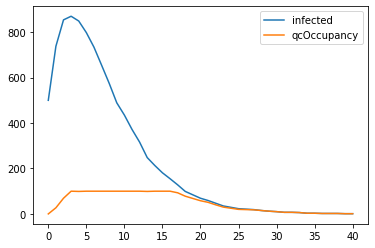

In [85]:

scenario23 = CONFIG(proportionInfected=0.50, qcLimit=100, quarantine=True)
plot_average_scenario(scenario23)

Average number of days before stabilisation: 74.6
Average day with peak infections (453.5): 7.9
Average number of casualties: 79.7


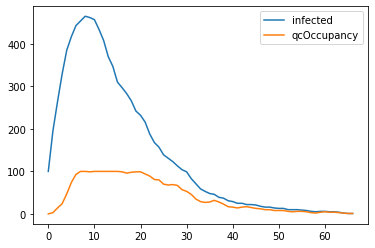

In [84]:

scenario31 = CONFIG(proportionInfected=0.1, qcLimit=100, quarantine=True, socialDistancing=True)
plot_average_scenario(scenario31)

Average number of days before stabilisation: 67.8
Average day with peak infections (475.2): 6.4
Average number of casualties: 81.6


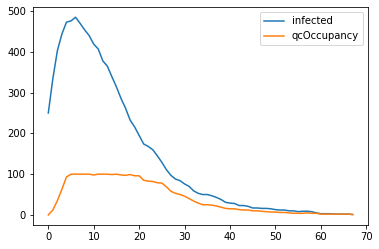

In [83]:

scenario32 = CONFIG(proportionInfected=0.25, qcLimit=100, quarantine=True, socialDistancing=True)
plot_average_scenario(scenario32)

Average number of days before stabilisation: 62.8
Average day with peak infections (579.9): 3.0
Average number of casualties: 81.8


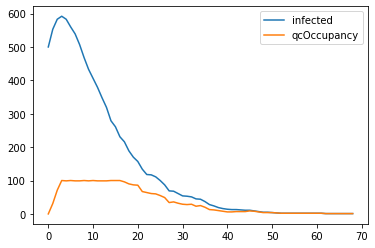

In [82]:
scenario33 = CONFIG(proportionInfected=0.50, qcLimit=100, quarantine=True, socialDistancing=True)
plot_average_scenario(scenario33)